### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from collections import Counter
import torch
import seaborn as sns

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')
    

Done


### Get data

In [2]:
### Get data
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.center_dist < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)
    
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

def get_paired_dfs(MCx_list, allDFs_MCx, allDFs_exec_MCx):

    ref_file = 'Chewie_RT_CS_2016-10-21.mat' #TODO: put in defs
    ref_i = [y for x,y in MCx_list].index(ref_file)
    df1 = allDFs_exec_MCx[ref_i]

    Mihili_files = GoodDataList['MCx']['Mihili']
    MrT_files = GoodDataList['MCx']['MrT']
    comparison_files = Mihili_files + MrT_files

    paired_dfs = []
    for ex_file in comparison_files:
        
        ex_i = [y for x,y in MCx_list].index(ex_file)
        df2 = allDFs_exec_MCx[ex_i]

        #subset dataframes with matched reaches
        df1_idx, df2_idx = defs.get_matched_reaches_idx(df1, df2)
        df1_subset = df1.iloc[df1_idx]
        df2_subset = df2.iloc[df2_idx]

        #get dataframes from whole-trial data
        df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
        df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

        #set target ids
        print(ex_file, len(df1_) - (df1_.target_group.values == df2_.target_group.values).sum(), 'diff target groups')
        df1_.target_group = df2_.target_group.values 
        df1_['target_id'] = df1_.target_group.values
        df2_['target_id'] = df2_.target_group.values

        #only keep target groups with enough trials
        counter = Counter(df1_.target_group)
        subset_target_groups = [k for k, c in counter.items() if c >= defs.min_trials_per_target]
        df1_ = df1_[df1_.target_group.isin(subset_target_groups)]
        df2_ = df2_[df2_.target_group.isin(subset_target_groups)]
        
        print(len(subset_target_groups), 'target groups left')

        paired_dfs.append((ex_file, df1_, df2_))
    
    return paired_dfs

In [3]:
MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()
paired_dfs = get_paired_dfs(MCx_list, allDFs_MCx, allDFs_exec_MCx)
# print(f'{len(paired_dfs)=}')

#example/ref session
ex_file = defs.ex_file
ref_file = defs.ref_file

#paired
ex_file_idx = [file for file,x,y in paired_dfs].index(ex_file)
print(ex_file_idx, ex_file)

#unpaired
i = [y for x,y in MCx_list].index(ex_file)
print('ex', i, ex_file)
ex_reaches_df = allDFs_exec_MCx[i]

i = [y for x,y in MCx_list].index(ref_file)
print('ref', i , ref_file)
ref_reaches_df = allDFs_exec_MCx[i]

Mihili_RT_VR_2014-01-14.mat 137 diff target groups
28 target groups left
Mihili_RT_FF_2014-02-24.mat 123 diff target groups
20 target groups left
Mihili_RT_FF_2014-02-14.mat 129 diff target groups
26 target groups left
Mihili_RT_VR_2014-01-15.mat 147 diff target groups
28 target groups left
Mihili_RT_VR_2014-01-16.mat 124 diff target groups
21 target groups left
Mihili_RT_FF_2014-02-21.mat 131 diff target groups
22 target groups left
MrT_RT_FF_2013-08-20.mat 97 diff target groups
14 target groups left
MrT_RT_FF_2013-08-22.mat 152 diff target groups
29 target groups left
MrT_RT_FF_2013-08-30.mat 123 diff target groups
16 target groups left
MrT_RT_VR_2013-09-10.mat 135 diff target groups
28 target groups left
0 Mihili_RT_VR_2014-01-14.mat
ex 10 Mihili_RT_VR_2014-01-14.mat
ref 0 Chewie_RT_CS_2016-10-21.mat


### Fig 3B: Example raw monkey reaches

Mihili_RT_VR_2014-01-14
Chewie_RT_CS_2016-10-21


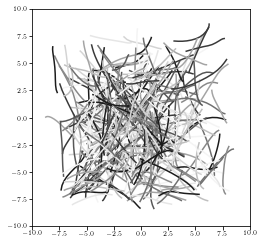

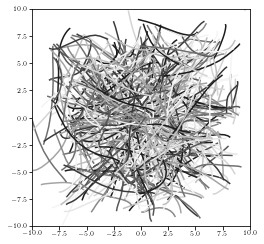

In [4]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)

#plot reaches for both reference and example file
for file, df in [(ex_file, ex_reaches_df), (ref_file,ref_reaches_df)]:
    #subset reaches that start around the center, movement only
    ntrials = len(df)
    plt.figure()
    with sns.color_palette("Greys", n_colors=10):
        for i in range(ntrials):
            pos = df.pos.values[i]
            # targets = exec_df.target_centered.values[i]
            angle = df.target_angle.values[i]
            plt.plot(*pos[:].T)
            # plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
    plt.gca().set_aspect(1)
    plt.xlim([-10,10])
    plt.ylim([-10,10])

    file_name = file[:-4]
    print(file_name)
    info = '_'.join([file_name])
    plt.savefig(params.figPath / ('RW-reaches-' + info + '.pdf'), format= 'pdf')

### Fig 3C: Example matched monkey reaches

<Figure size 3600x2400 with 0 Axes>

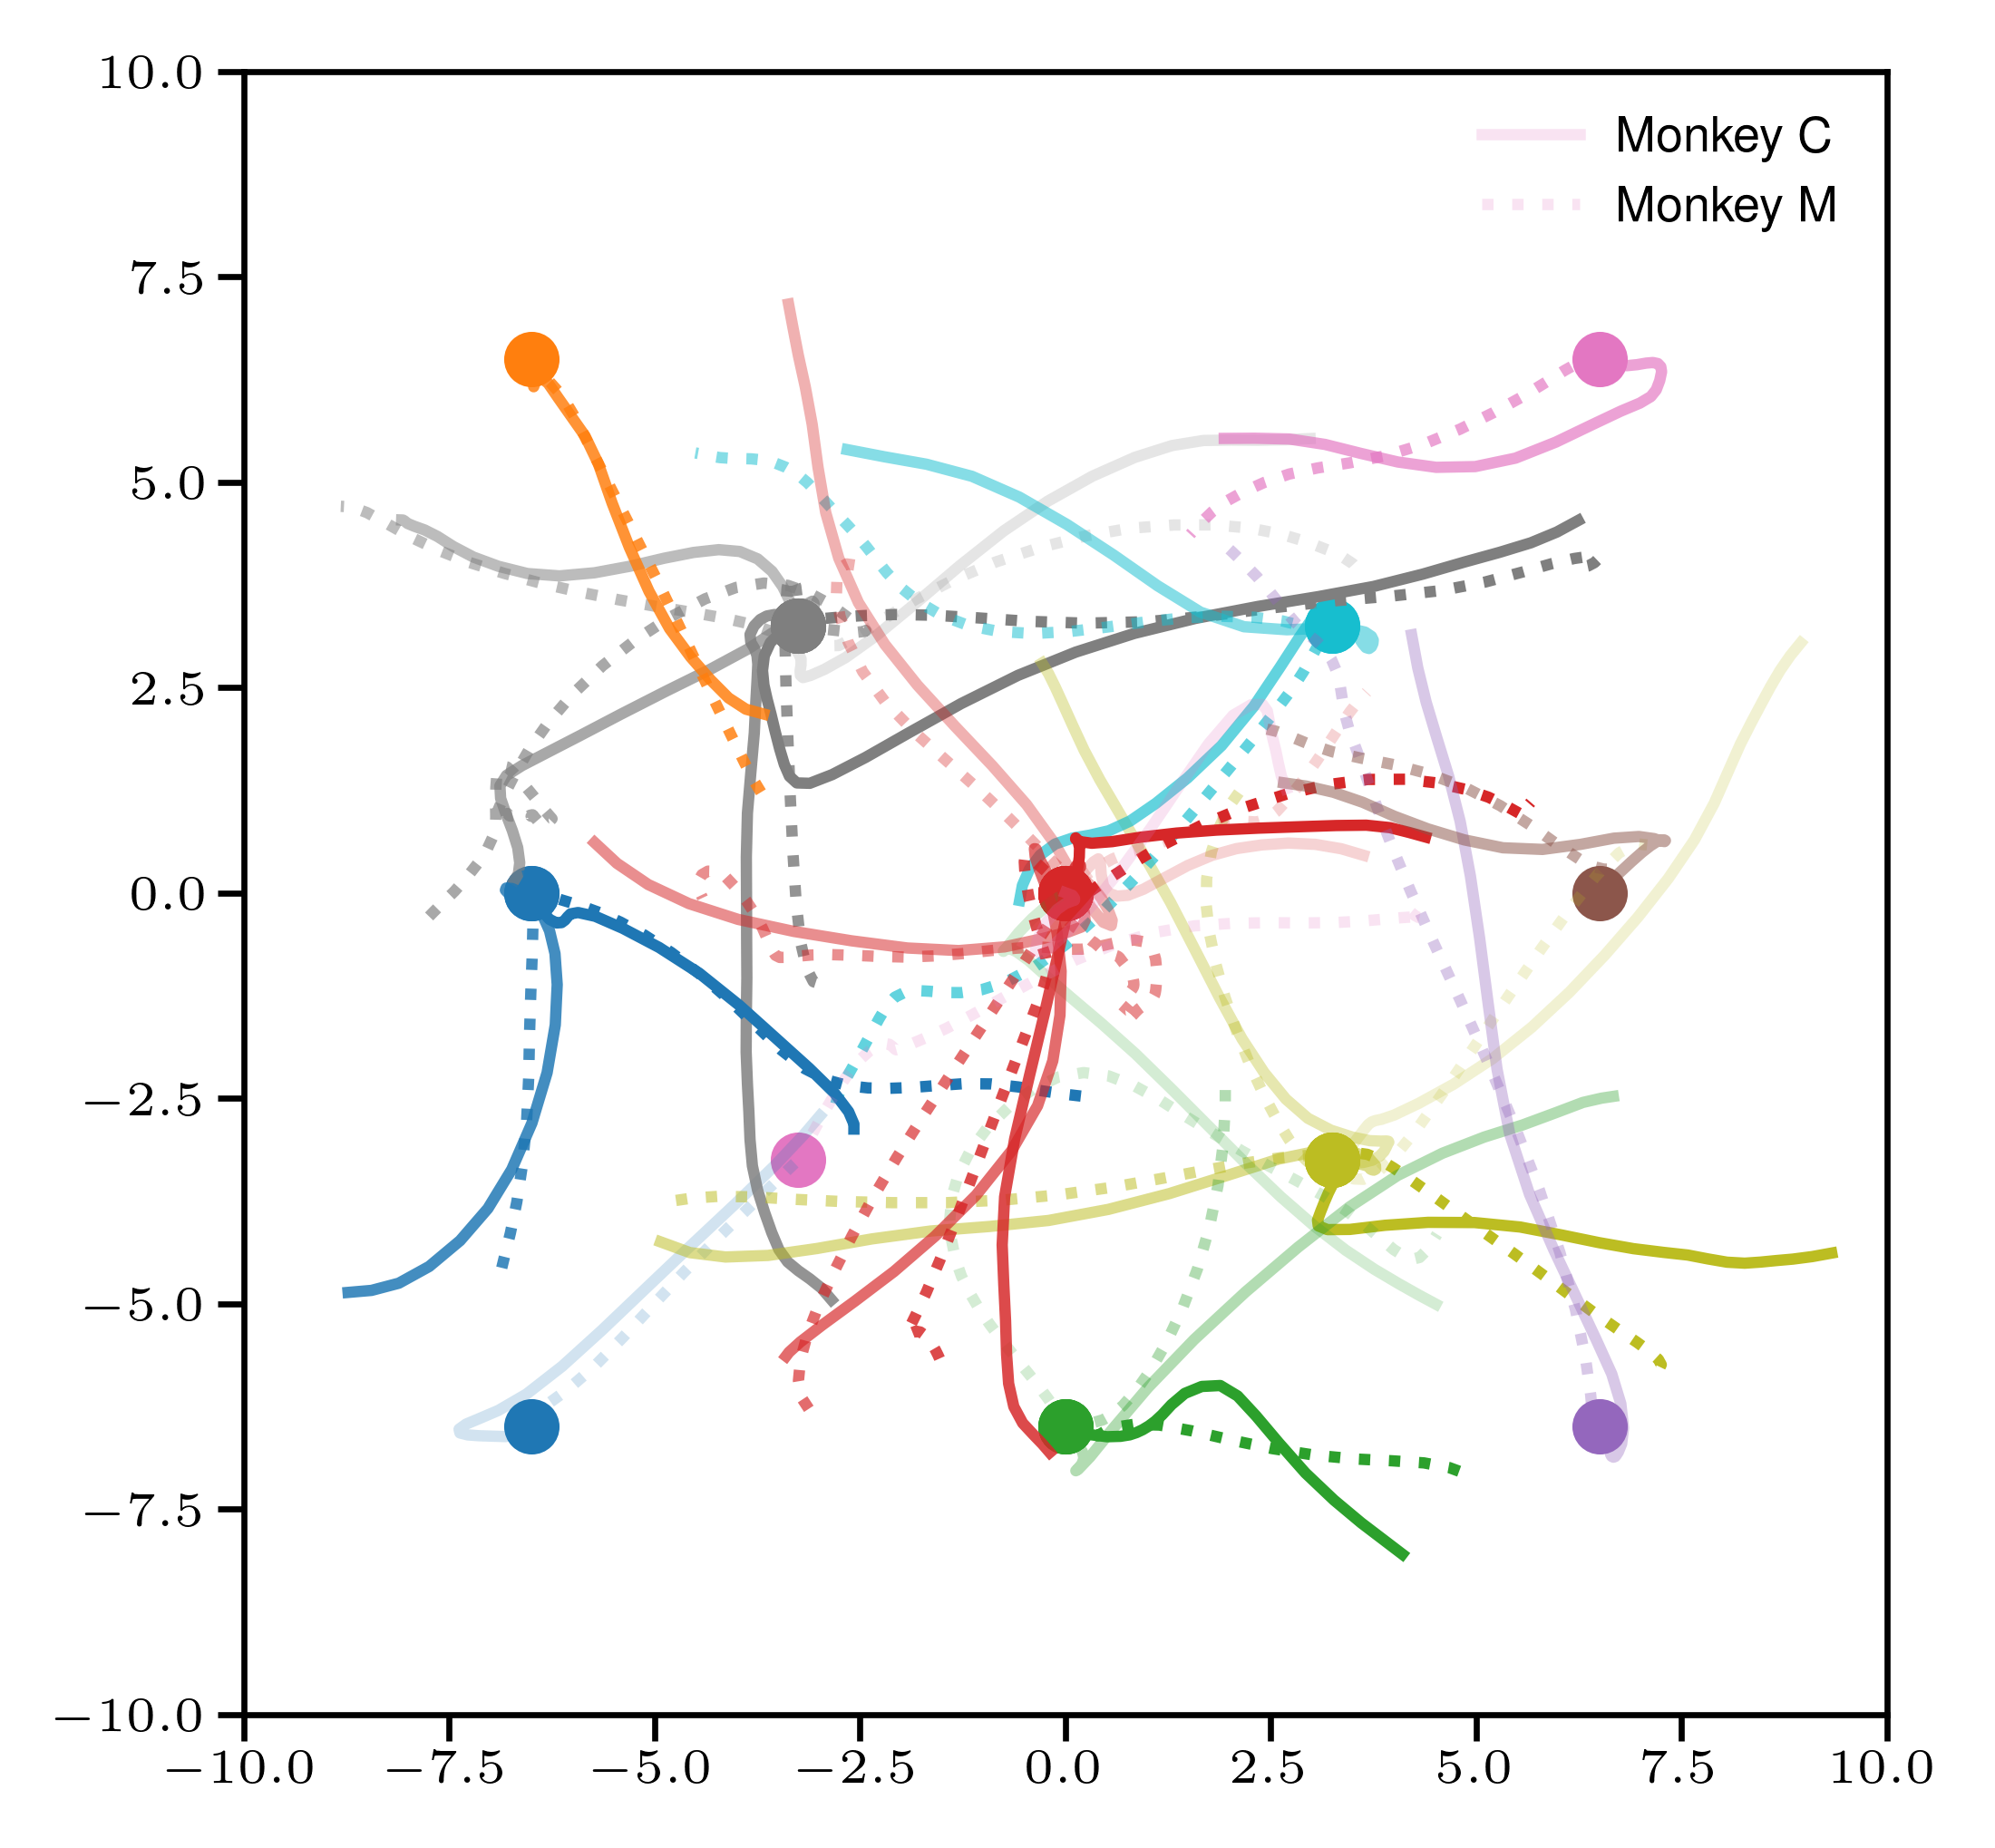

In [25]:
ex_file, df1_, df2_ = paired_dfs[ex_file_idx]

#plot matched reaches
plt.figure()
ntrials = 10
colors = utility.get_colors(13, 'tab10')
alphas = np.linspace(0.2,1,defs.n_angle_groups)
# alphas = np.ones(defs.n_angle_groups)
target_groups = defs.target_groups
plt.figure()
df = df1_

subset_target_groups = np.unique(df1_.target_group)

center_ids = []
for tar in subset_target_groups[:]:
    df1__ = df1_[df1_.target_group == tar]
    df2__ = df2_[df2_.target_group == tar]

    center_id = df2__.center_id.values[0]
    angle_group = df2__.angle_group.values[0]
    # if center_id in center_ids: continue #plot 1 target/center ID

    center_ids.append(center_id)
    center = df2__.center.values[0]
    plt.scatter(center[0], center[1], s = 40, c= colors[center_id])

    for i in range(1):
        pos = df1__.pos_centered.values[i]
        # pos = df1__.pos.values[i]
        # targets = df1__.target_centered.values[i]

        plt.plot(*pos[:].T, c=colors[center_id], label = 'Monkey C', alpha = alphas[angle_group])
        # plt.scatter(*targets[:].T, s = 10, c=colors[center_id])

        pos = df2__.pos_centered.values[i]
        # pos = df2__.pos.values[i]
        # targets = df2__.target_centered.values[i]
        plt.plot(*pos[:].T, c=colors[center_id], linestyle = 'dotted', label = 'Monkey M', alpha = alphas[angle_group])
        # plt.scatter(*targets[:].T, s = 10, c=colors[color_idx],marker = '^')
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])

info = '_'.join([file_name])
plt.savefig(params.figPath / ("RW-paired_reaches_all_targets"+info+'.pdf'), format='pdf')

### Fig 3D: Example CCA

In [5]:
def get_alignments(df1, df2):
    allCCs=[]
    CCsL=[]
    CCsU=[]
    
    subset_target_groups = np.unique(df1.target_group)

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1, df2, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    
    return allCCs, CCsL, CCsU

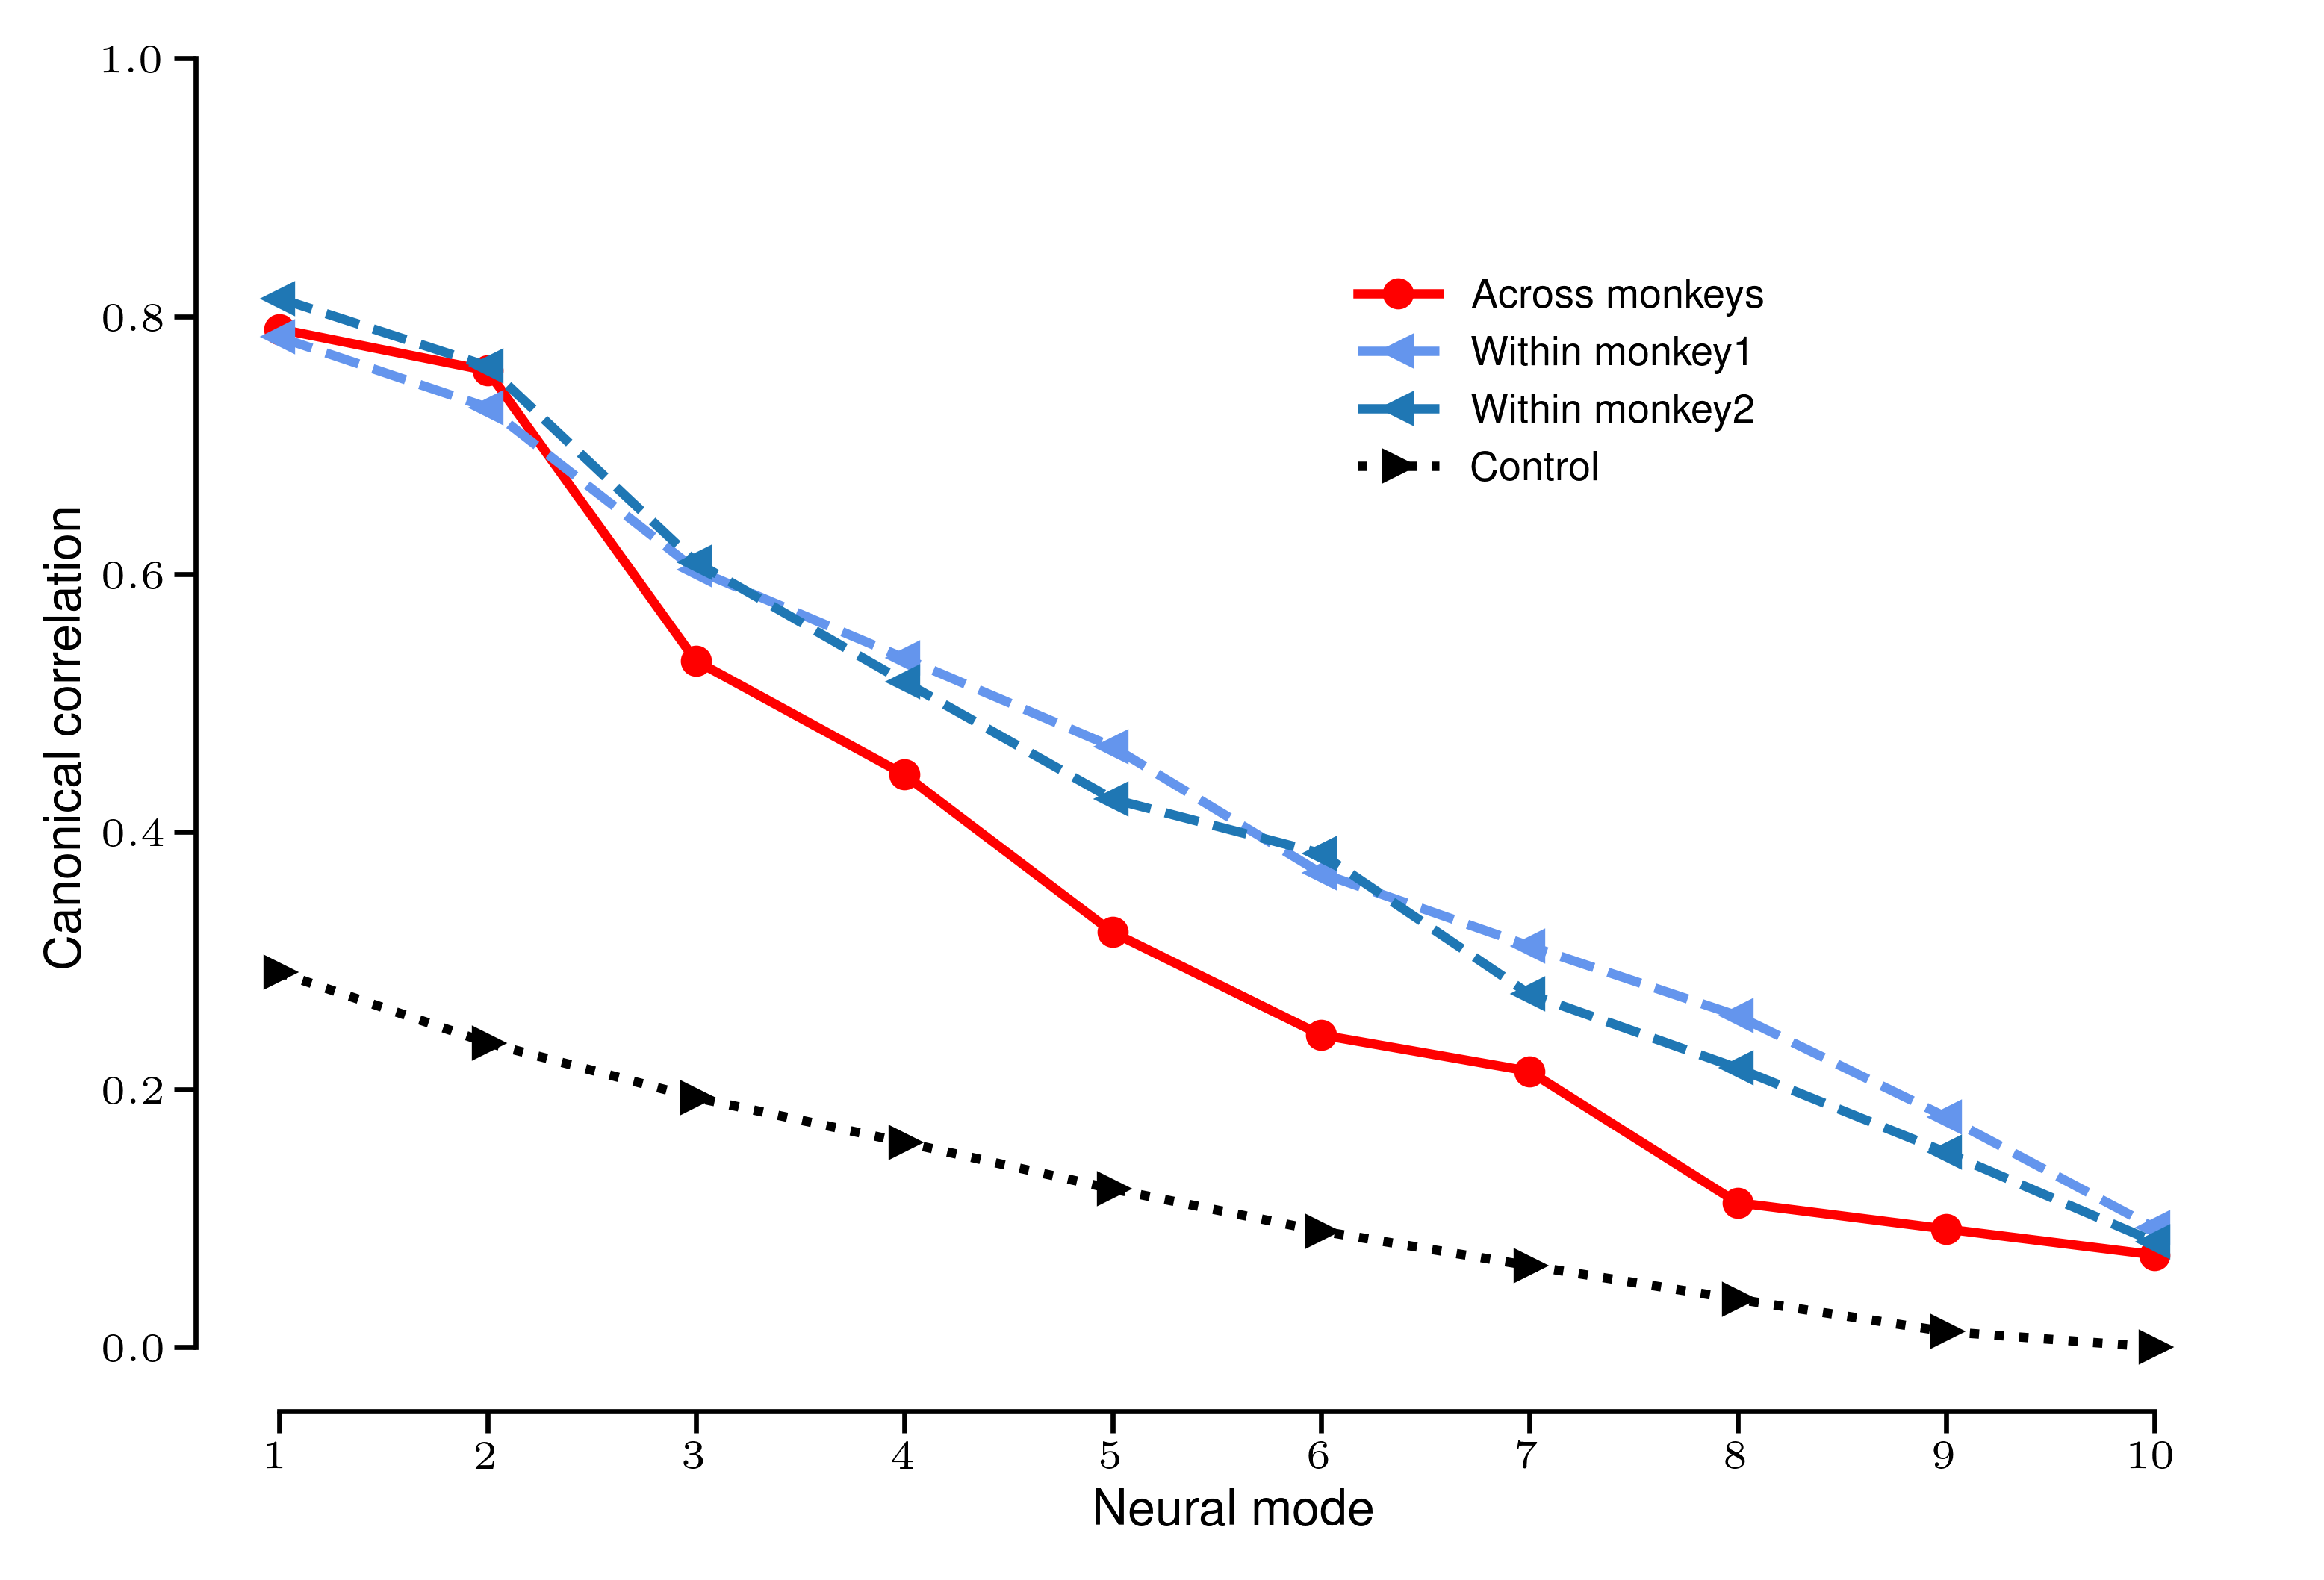

In [16]:
#cca
ex_file, df1_, df2_ = paired_dfs[ex_file_idx]
allCCs, CCsL, CCsU = get_alignments(df1_, df2_)

allCCs = np.array(allCCs).T
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
fig, ax = plt.subplots()
x_ = np.arange(1,defs.n_components+1)
ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')

ax.set_ylim([-.05,1])
ax.set_xlim([.6,defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_title(f'{defs.areas[2]} Alignment')
ax.legend(loc=(.55,.67))
ax.set_ylabel('Canonical correlation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])

info = '_'.join([ex_file[:-4]])

fig.savefig(params.figPath / ('RW-CCA-' + info + '.pdf'), format='pdf', bbox_inches='tight')

### Fig 3E: CCA for all sessions

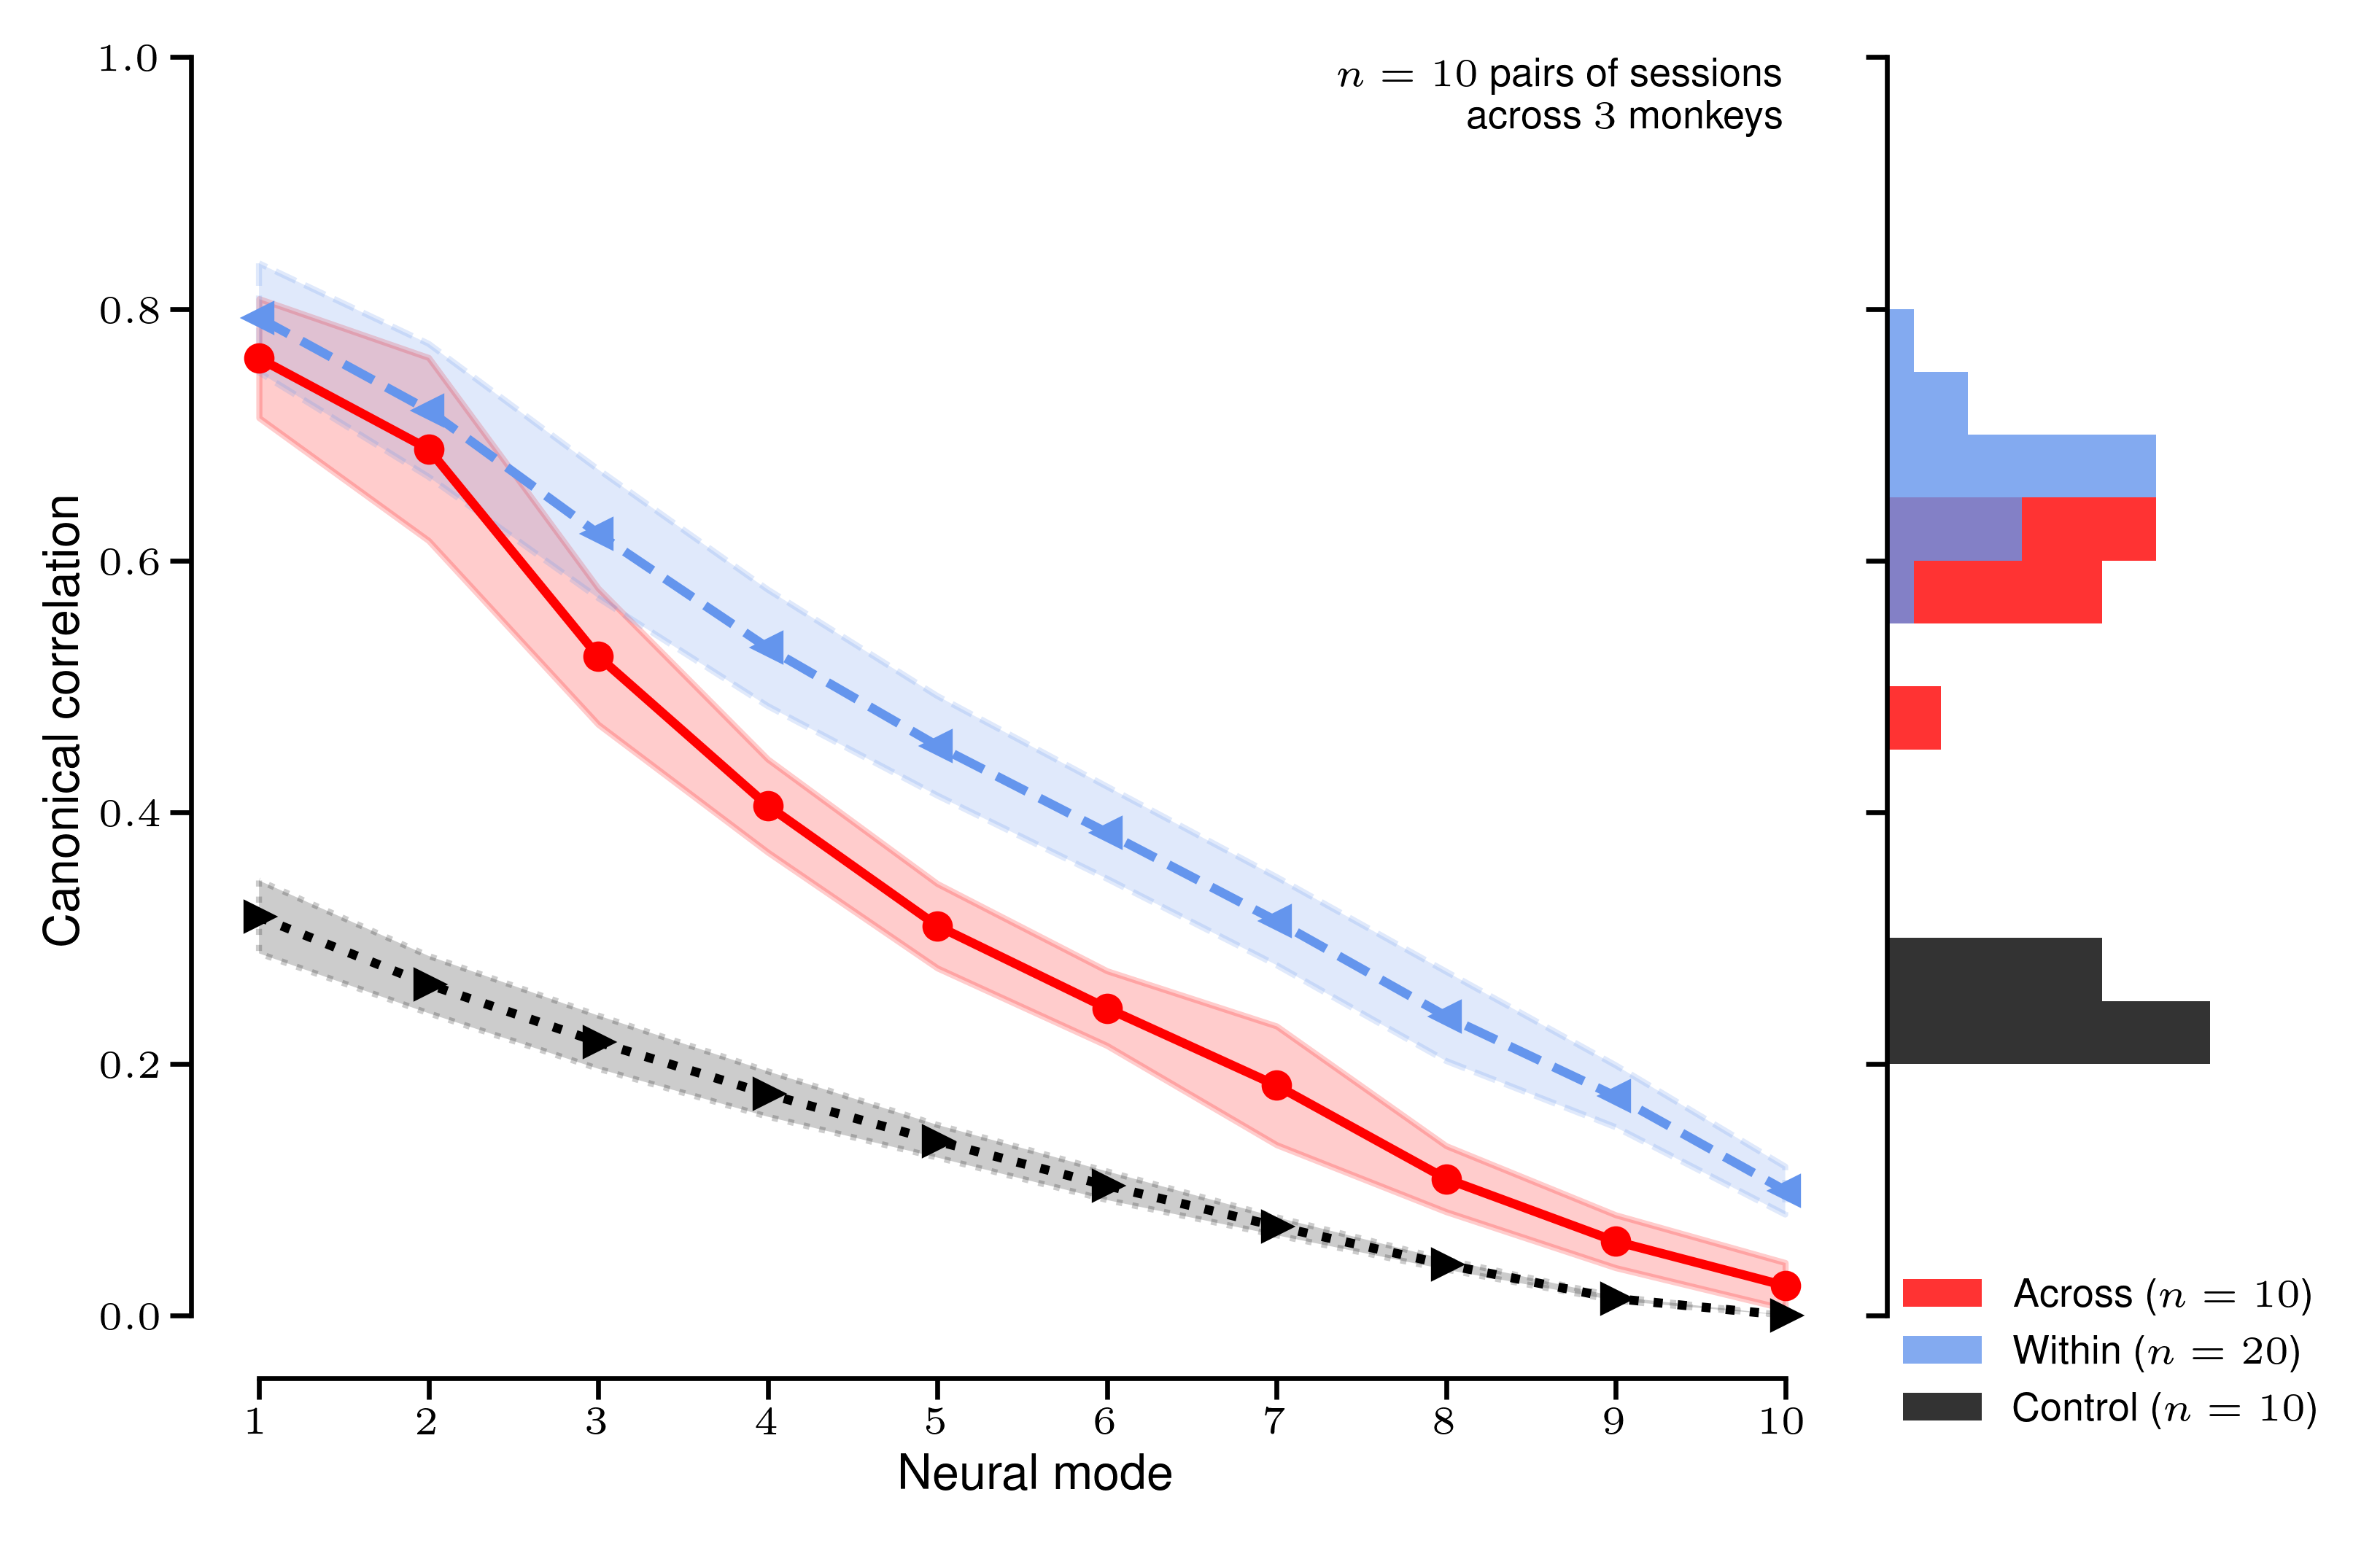

In [6]:
allCCs=[]
CCsL=[]
CCsU=[]

for ex_file, df1_, df2_ in paired_dfs:
    allCCs_, CCsL_, CCsU_ = get_alignments(df1_, df2_)

    allCCs.extend(allCCs_)
    CCsL.extend(CCsL_)
    CCsU.extend(CCsU_)

allCCs = np.array(allCCs).T
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])


x_ = np.arange(1,defs.n_components+1)
utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

ax.set_ylim([-.05,1])
ax.set_xlim([.6, defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Canonical correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])
ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
        ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])


bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))

fig.savefig(params.figPath / 'RW-CCA.pdf', format='pdf', bbox_inches='tight')

### Fig 3F: CCA based on number of conditions


In [10]:
redo = False
import random
import itertools
from tqdm.auto import tqdm

subset_CCs = []
for ex_file, df1_, df2_ in paired_dfs:
    # if ex_file != 'Mihili_RT_VR_2014-01-14.mat': continue

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    #get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_targets_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            allCCs_subset = pickle.load(f)
    else: 
        target_groups = np.unique(df1_.target_group)
        n_target_groups = len(target_groups)

        #remove n target groups
        allCCs_subset = []
        for n in tqdm(range(2,n_target_groups+1)):
            allCCs_subset_ = []
            comb = list(itertools.combinations(range(n_target_groups), n))
            # print(n, len(comb))
            comb = random.sample(comb, min(len(comb),10000)) #do max 10000 combos
            for target_idx in comb:
                AllData1_ = AllData1[:, target_idx,:,:,:]
                AllData2_ = AllData2[:, target_idx,:,:,:]

                for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
                    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    allCCs_subset_.append(dt.canoncorr(data1, data2))
            allCCs_subset.append(np.array(allCCs_subset_).T) 
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(allCCs_subset, f)   
    print(ex_file, len(allCCs_subset))
    subset_CCs.append(allCCs_subset)

Mihili_RT_FF_2014-02-14.mat 25
Mihili_RT_VR_2014-01-15.mat 27
Mihili_RT_VR_2014-01-16.mat 20
Mihili_RT_FF_2014-02-24.mat 19
Mihili_RT_FF_2014-02-21.mat 21
Mihili_RT_VR_2014-01-14.mat 27
MrT_RT_VR_2013-09-10.mat 27
MrT_RT_FF_2013-08-20.mat 13
MrT_RT_FF_2013-08-22.mat 28
MrT_RT_FF_2013-08-30.mat 15


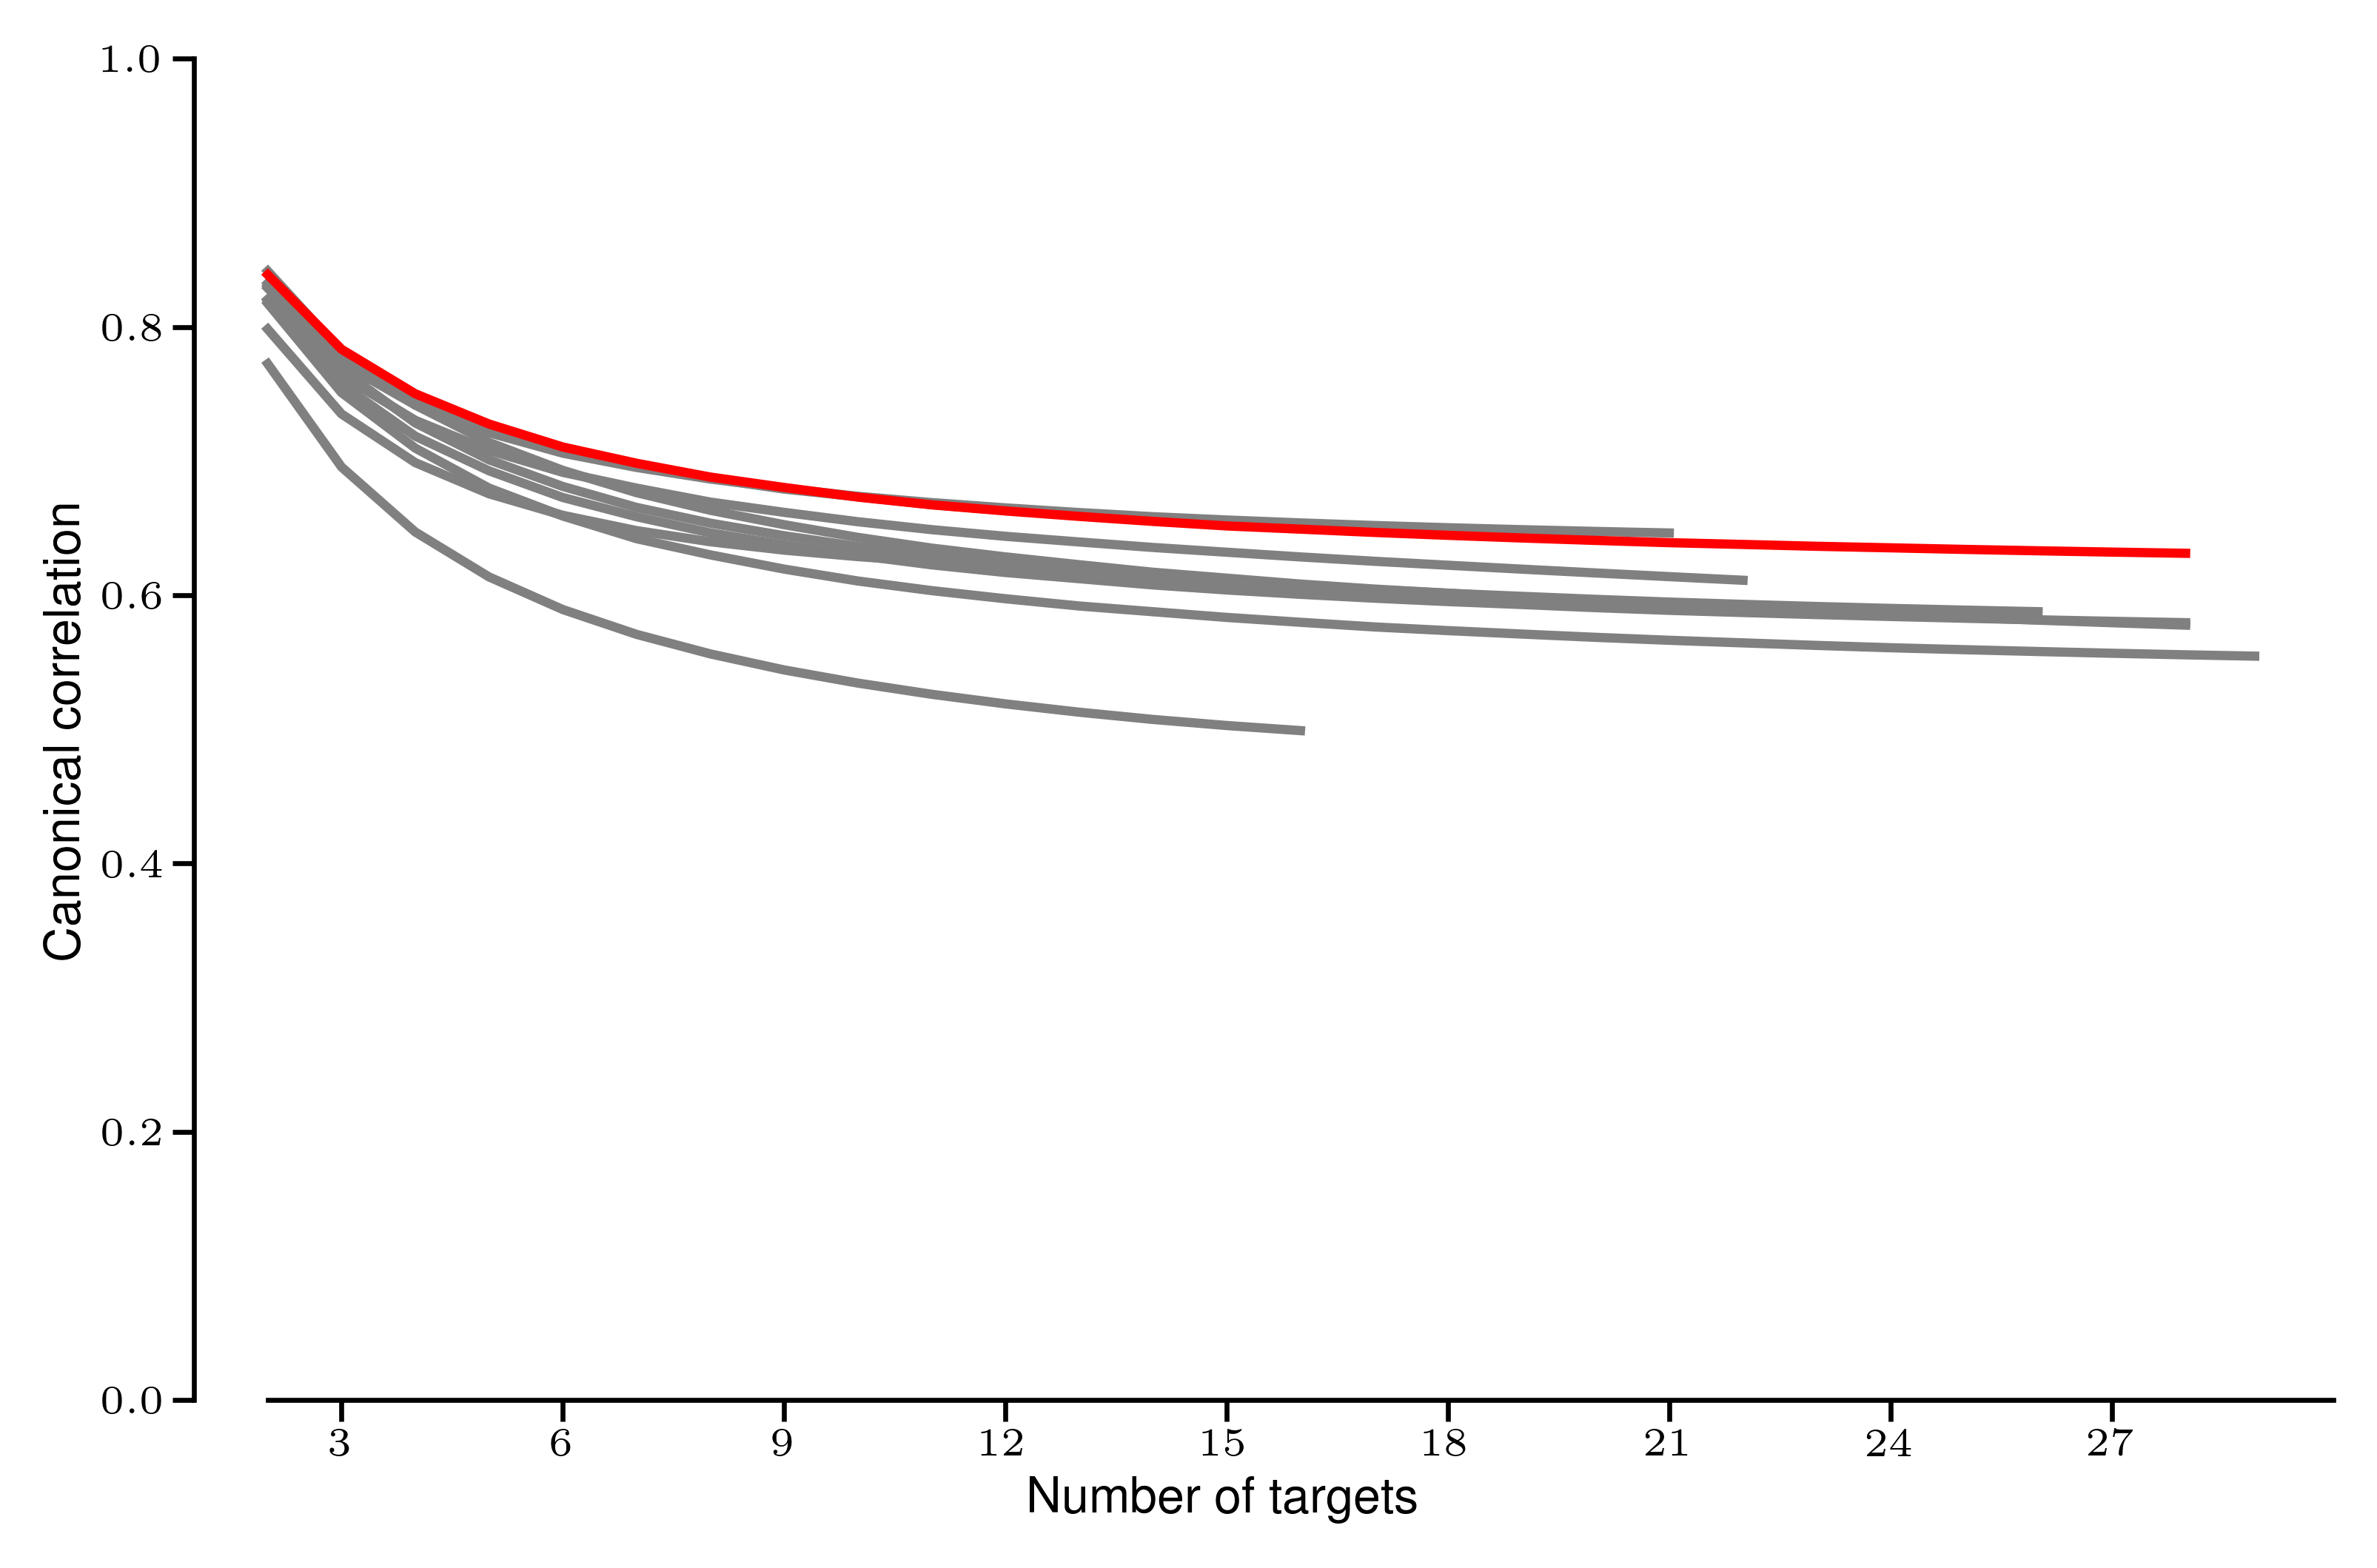

In [11]:
session_colors = utility.get_colors(len(subset_CCs))
fig, ax = plt.subplots()

for i, allCCs_subset in enumerate(subset_CCs):
    all_mean_ccs = [np.mean(x[:4],axis = 0) for x in allCCs_subset]
    mean_ccs = [np.mean(x) for x in all_mean_ccs]

    n_target_groups = len(mean_ccs)+2
    x = range(2, n_target_groups)
    colors = utility.get_colors(n_target_groups)

    if i == ex_file_idx:
        ax.plot(x, mean_ccs, c = 'red')
    else:
        ax.plot(x, mean_ccs, c = 'grey')

    plt.xlabel('Number of targets')
    plt.ylabel('Canonical correlation')
    plt.ylim([0,1])
    plt.xlim([1,29])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([2,30])
    ax.spines['left'].set_bounds([0,1])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    
info = '_'.join([str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
plt.savefig(params.figPath / ("RW-mean_cca_subset_targets_"+info+'.pdf'), format= 'pdf')

### Fig 3G: CCA based on number of neurons

In [18]:
def keep_neurons(df, n_keep, signal):
    df_ = df.copy()
    n_neurons = df_[signal].values[0].shape[1]
    if n_neurons < n_keep:
        return False
    mask = params.rng.choice(n_neurons, n_keep, replace = False)
    df_[signal] = [arr[:, mask] for arr in df_[signal]]
    
    return df_

n_step = 10
n_per_removal = 10
def cca_sub_neurons_inc(df1, df2, ex_file, redo = False):
    # get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_neurons_keep_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            CC_corr_subsample = pickle.load(f)
    else: 

        #successively keep more neurons
        signal = defs.areas[2] + '_rates'

        n_neurons1 = df1[signal].values[0].shape[1]
        n_neurons2 = df2[signal].values[0].shape[1]
        
        n_iter = 50

        CC_corr_subsample = []
        for n_keep in range(defs.n_components+1, 1000, n_step):
            #remove neurons
            df1_ = keep_neurons(df1, n_keep, signal)
            df2_ = keep_neurons(df2, n_keep, signal)
            if df1_ is False or df2_ is False:
                break

            CC_corr=[]
            for j in tqdm(range(n_iter)):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        
                *_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
                data1 = np.reshape(AllData1[0,:min_trials,:min_time,:], (-1,defs.n_components))
                data2 = np.reshape(AllData2[0,:min_trials,:min_time,:], (-1,defs.n_components))
                CC_corr.append(dt.canoncorr(data1, data2)[:4].mean())
            CC_corr_subsample.append(np.array(CC_corr))
            # CC_corr_subsample.append(np.mean(CC_corr))
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(np.array(CC_corr_subsample), f)   
        
    return CC_corr_subsample


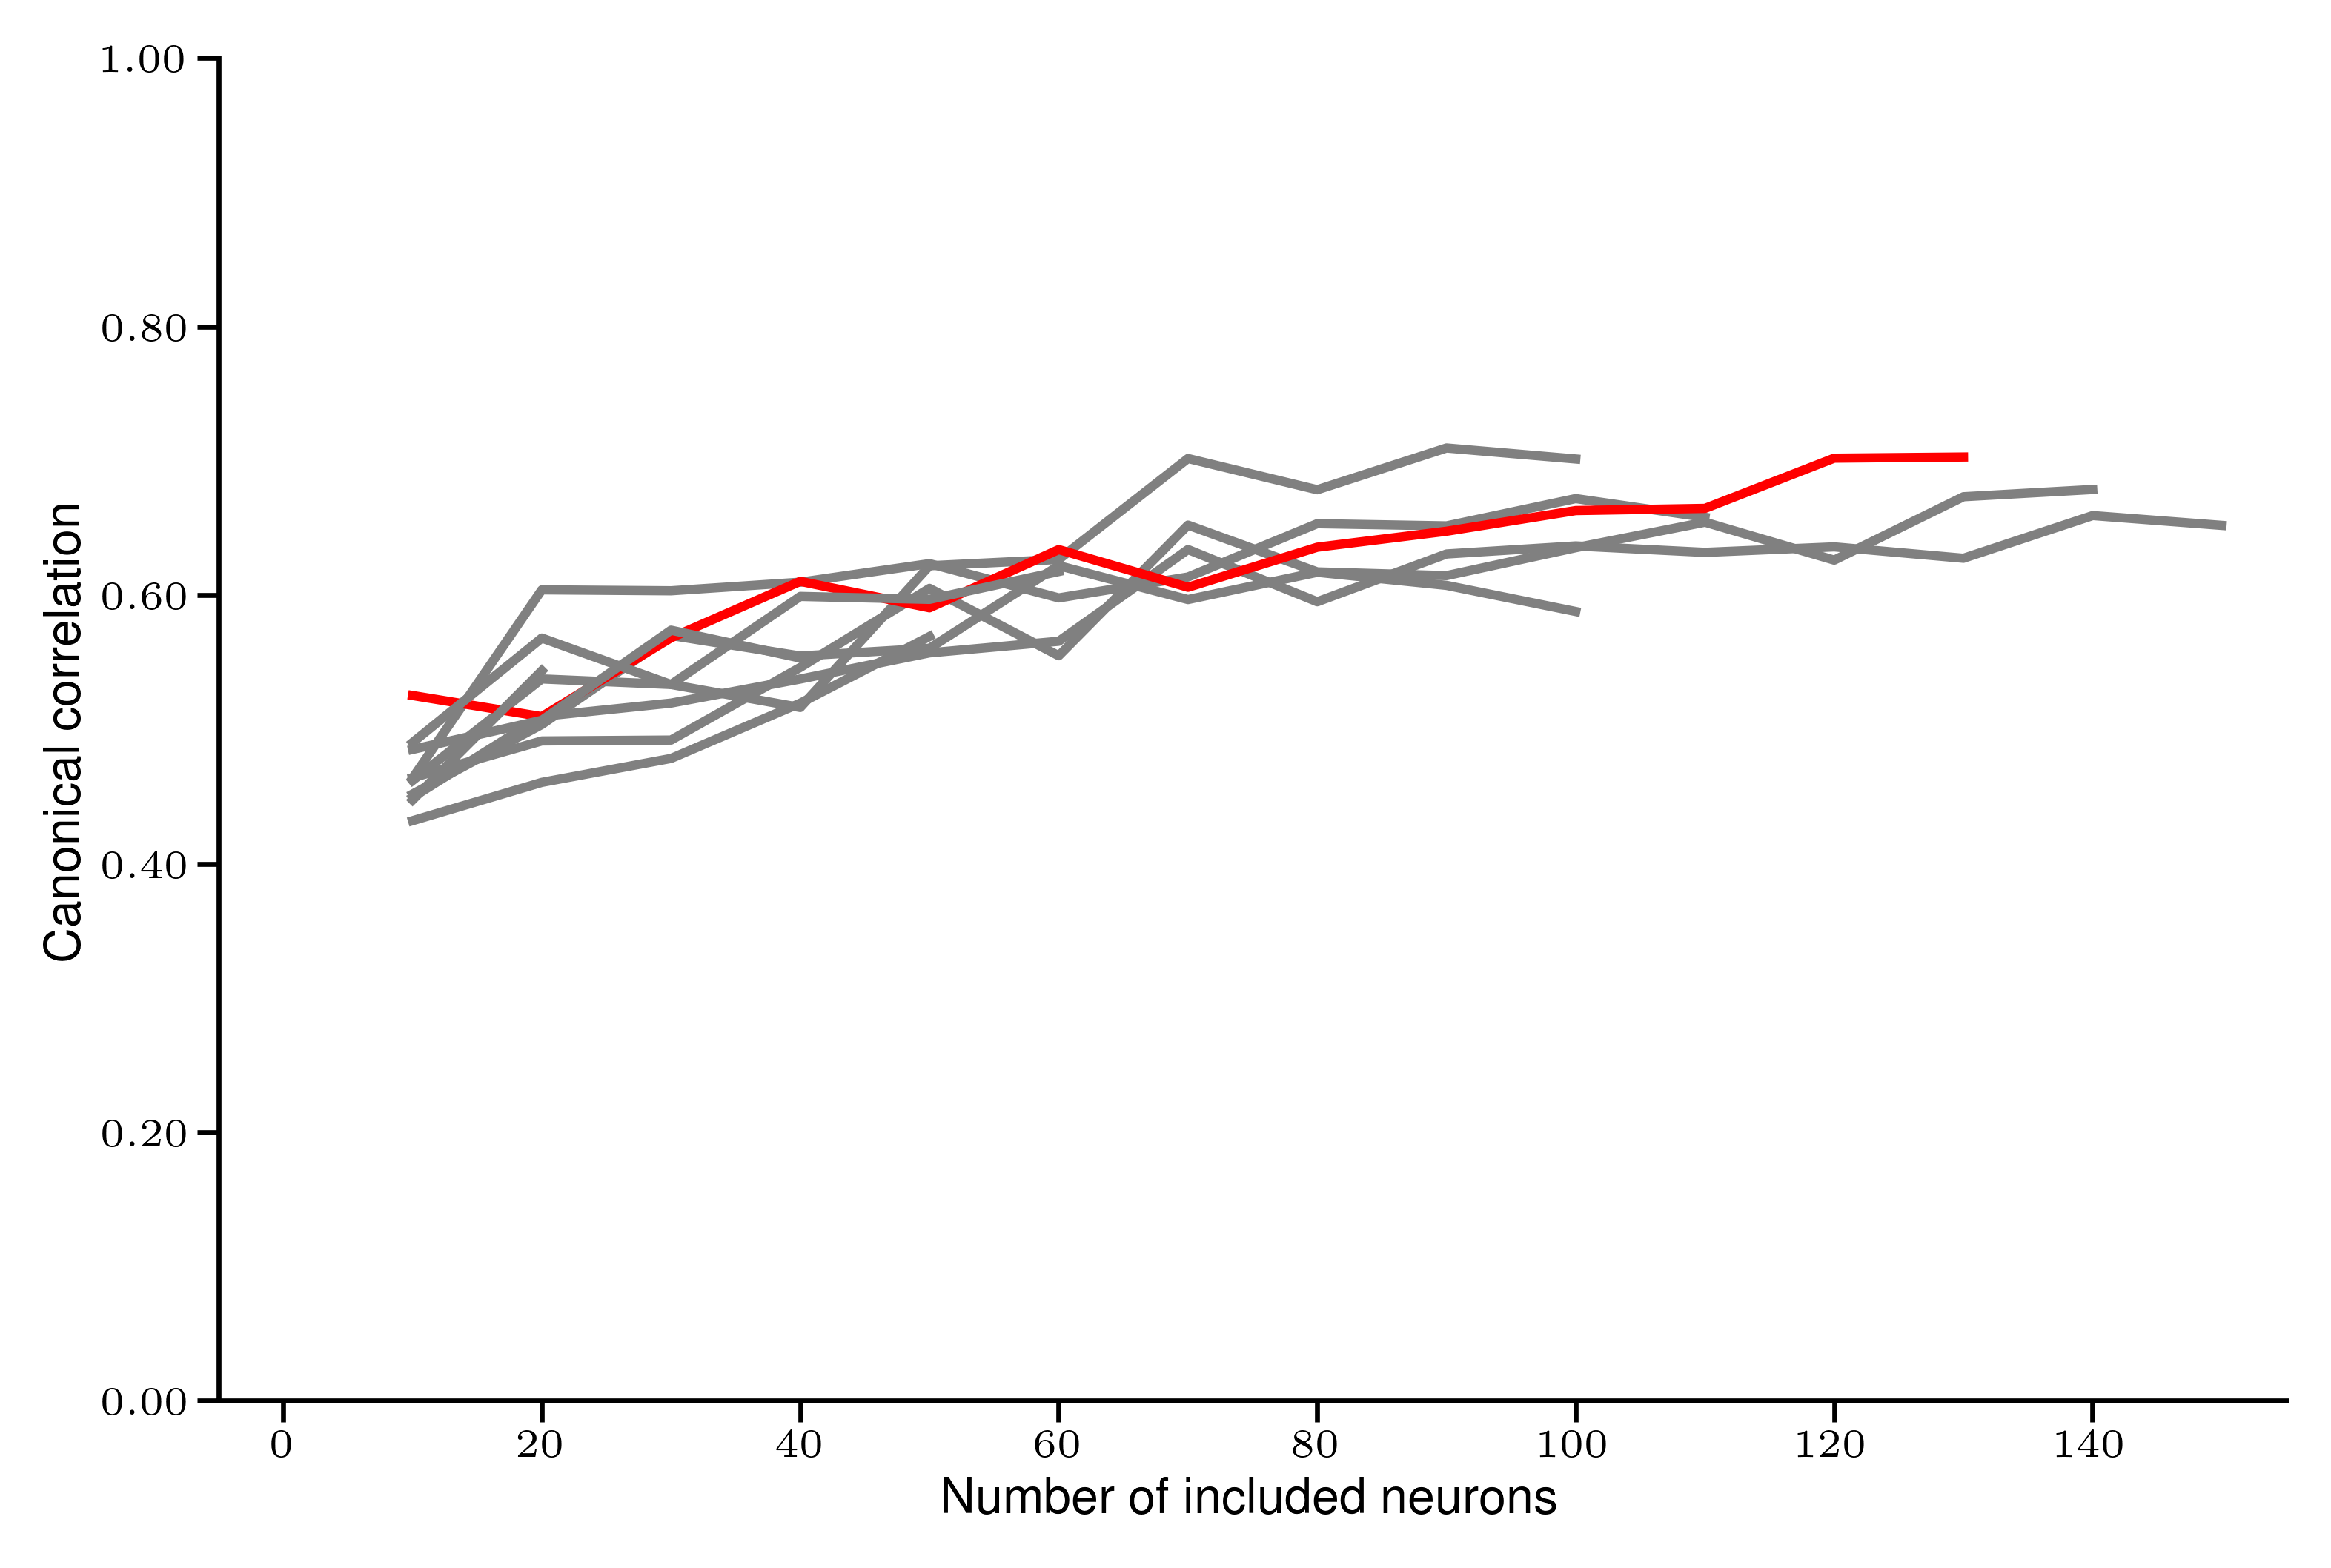

In [19]:
CC_corr_subsample= []
for ex_file, df1_, df2_ in paired_dfs:
    ccs = np.array(cca_sub_neurons_inc(df1_,df2_, ex_file,redo = False))
    mean_ccs = np.mean(ccs,axis=1)
    CC_corr_subsample.append(mean_ccs)

# Plotting
set_rc()
fig, ax = plt.subplots()

for i,cc in enumerate(CC_corr_subsample):
    if i == ex_file_idx:
        ax.plot((np.arange(len(cc))*n_step)+defs.n_components, np.array(cc), color=params.colors.MainCC)
    else: 
        ax.plot((np.arange(len(cc))*n_step)+defs.n_components, np.array(cc), color='grey')

ax.set_xlabel('Number of included neurons')
ax.set_ylabel('Canonical correlation')
ax.set_ylim([0,1])
ax.set_xlim([-.5*n_per_removal, max([len(cc) for cc in CC_corr_subsample])*n_per_removal+5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

fig.savefig(params.figPath / 'RW-neuron-keep.pdf', format='pdf', bbox_inches='tight')

